<a href="https://colab.research.google.com/github/leilanorouzi/DataScinceProjects/blob/master/GAN_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#! pip3 install -q tensorflow-gpu==2.1.0

In [20]:
import tensorflow as tf
print(tf.__version__)
print("GPU Available:", tf.test.is_gpu_available())
if tf.test.is_gpu_available():
  device_name = tf.test.gpu_device_name()
else:
  device_name = '/CPU:0'
print(device_name)

2.8.0
GPU Available: True
/device:GPU:0


In [21]:
#!pip install tensorflow_datasets


In [22]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [23]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [24]:
def make_generator_network(
    num_hidden_layers=1,
    num_hidden_units=100,
    num_output_units=784):
      model = tf.keras.Sequential()
      for i in range(num_hidden_layers):
        model.add(
            tf.keras.layers.Dense(
                units=num_hidden_units, use_bias=False))
        model.add(tf.keras.layers.LeakyReLU())
      model.add(
        tf.keras.layers.Dense(
            units=num_output_units, activation='tanh'))
      return model

In [25]:
def make_discriminator_network(
    num_hidden_layers=1,
    num_hidden_units=100,
    num_output_units=1):
      model = tf.keras.Sequential()
      for i in range(num_hidden_layers):
        model.add(
            tf.keras.layers.Dense(units=num_hidden_units))
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(rate=0.5))
      model.add(
          tf.keras.layers.Dense(
              units=num_output_units, activation=None))
      return model

In [26]:
image_size = (28, 28)
z_size = 20
mode_z = 'uniform' # 'uniform' vs. 'normal'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100
tf.random.set_seed(1)
gen_model = make_generator_network(
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))
gen_model.build(input_shape=(None, z_size))
gen_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               2000      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 784)               79184     
                                                                 
Total params: 81,184
Trainable params: 81,184
Non-trainable params: 0
_________________________________________________________________


In [27]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)
def preprocess(ex, mode='uniform'):
  image = ex['image']
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.reshape(image, [-1])
  image = image*2 - 1.0
  if mode == 'uniform':
    input_z = tf.random.uniform(
        shape=(z_size,), minval=-1.0, maxval=1.0)
  elif mode == 'normal':
    input_z = tf.random.normal(shape=(z_size,))
  return input_z, image
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)

In [28]:
disc_model = make_discriminator_network(
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)
disc_model.build(input_shape=(None, np.prod(image_size)))
disc_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 100)               78500     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 100)               0         
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


In [29]:
mnist_trainset = mnist_trainset.batch(32, drop_remainder=True)
input_z, input_real = next(iter(mnist_trainset))
print('input-z -- shape:   ', input_z.shape)
print('input-real -- shape:', input_real.shape)
g_output = gen_model(input_z)
print('Output of G -- shape:', g_output.shape)
d_logits_real = disc_model(input_real)
d_logits_fake = disc_model(g_output)
print('Disc. (real) -- shape:', d_logits_real.shape)
print('Disc. (fake) -- shape:', d_logits_fake.shape)

input-z -- shape:    (32, 20)
input-real -- shape: (32, 784)
Output of G -- shape: (32, 784)
Disc. (real) -- shape: (32, 1)
Disc. (fake) -- shape: (32, 1)


In [30]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
## Loss for the Generator
g_labels_real = tf.ones_like(d_logits_fake)
g_loss = loss_fn(y_true=g_labels_real, y_pred=d_logits_fake)
print('Generator Loss: {:.4f}'.format(g_loss))
## Loss for the Discriminator
d_labels_real = tf.ones_like(d_logits_real)
d_labels_fake = tf.zeros_like(d_logits_fake)
d_loss_real = loss_fn(y_true=d_labels_real,
                      y_pred=d_logits_real)
d_loss_fake = loss_fn(y_true=d_labels_fake,
                      y_pred=d_logits_fake)
print('Discriminator Losses: Real {:.4f} Fake {:.4f}'.format(d_loss_real.numpy(), d_loss_fake.numpy()))

Generator Loss: 0.7355
Discriminator Losses: Real 1.5073 Fake 0.6583


In [ ]:
import time
num_epochs = 100
batch_size = 64
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100
tf.random.set_seed(1)
np.random.seed(1)
if mode_z == 'uniform':
  fixed_z = tf.random.uniform(
      shape=(batch_size, z_size),
      minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))
def create_samples(g_model, input_z):
  g_output = g_model(input_z, training=False)
  images = tf.reshape(g_output, (batch_size, *image_size))
  return (images+1)/2.0
## Set-up the dataset
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(
    lambda ex: preprocess(ex, mode=mode_z))
mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)
## Set-up the model
with tf.device(device_name):
  gen_model = make_generator_network(
      num_hidden_layers=gen_hidden_layers,
      num_hidden_units=gen_hidden_size,
      num_output_units=np.prod(image_size))
  gen_model.build(input_shape=(None, z_size))
  disc_model = make_discriminator_network(
      num_hidden_layers=disc_hidden_layers,
      num_hidden_units=disc_hidden_size)
  disc_model.build(input_shape=(None, np.prod(image_size)))
## Loss function and optimizers:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()
all_losses = []
all_d_vals = []
epoch_samples = []
start_time = time.time()
for epoch in range(1, num_epochs+1):
  epoch_losses, epoch_d_vals = [], []
  for i,(input_z,input_real) in enumerate(mnist_trainset):
    ## Compute generator's loss
    with tf.GradientTape() as g_tape:
      g_output = gen_model(input_z)
      d_logits_fake = disc_model(g_output,
                                 training=True)
      labels_real = tf.ones_like(d_logits_fake)
      g_loss = loss_fn(y_true=labels_real,
                       y_pred=d_logits_fake)

## Compute the gradients of g_loss
g_grads = g_tape.gradient(g_loss,
                          gen_model.trainable_variables)

## Optimization: Apply the gradients
g_optimizer.apply_gradients(
    grads_and_vars=zip(g_grads,
                       gen_model.trainable_variables))
## Compute discriminator's loss
with tf.GradientTape() as d_tape:
  d_logits_real = disc_model(input_real,
                             training=True)
  d_labels_real = tf.ones_like(d_logits_real)
  d_loss_real = loss_fn(
      y_true=d_labels_real, y_pred=d_logits_real)
  d_logits_fake = disc_model(g_output,
                             training=True)
  d_labels_fake = tf.zeros_like(d_logits_fake)
  d_loss_fake = loss_fn(
      y_true=d_labels_fake, y_pred=d_logits_fake)
  d_loss = d_loss_real + d_loss_fake
  ## Compute the gradients of d_loss
  d_grads = d_tape.gradient(d_loss,
                            disc_model.trainable_variables)
  ## Optimization: Apply the gradients
  d_optimizer.apply_gradients(
      grads_and_vars=zip(d_grads,
                         disc_model.trainable_variables))
  epoch_losses.append(
      (g_loss.numpy(), d_loss.numpy(),
       d_loss_real.numpy(), d_loss_fake.numpy()))
  d_probs_real = tf.reduce_mean(
      tf.sigmoid(d_logits_real))
  d_probs_fake = tf.reduce_mean(
      tf.sigmoid(d_logits_fake))
  epoch_d_vals.append((d_probs_real.numpy(),
                       d_probs_fake.numpy()))
  all_losses.append(epoch_losses)
  all_d_vals.append(epoch_d_vals)
  print(
      'Epoch {:03d} | ET {:.2f} min | Avg Losses >>'
      ' G/D {:.4f}/{:.4f} [D-Real: {:.4f} D-Fake: {:.4f}]'
      .format(
          epoch, (time.time() - start_time)/60,
          *list(np.mean(all_losses[-1], axis=0))))
  epoch_samples.append(
      create_samples(gen_model, fixed_z).numpy())
  

Epoch 100 | ET 18.17 min | Avg Losses >> G/D 0.6903/1.1837 [D-Real: 0.4713 D-Fake: 0.7123]


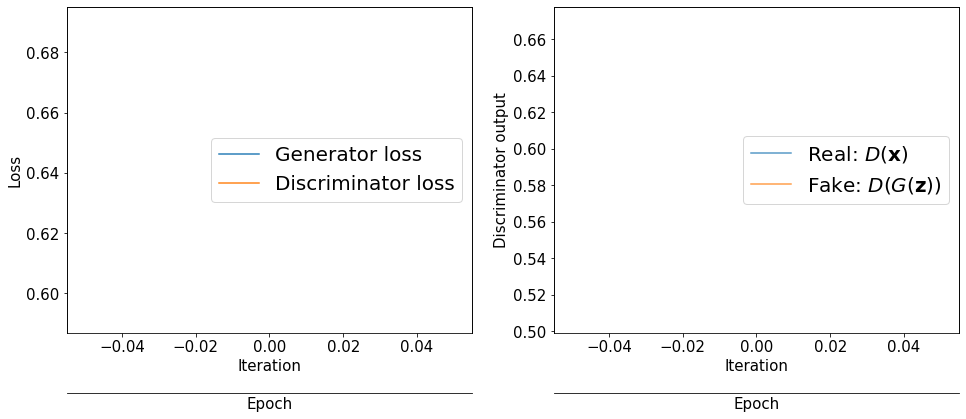

In [36]:
import itertools
fig = plt.figure(figsize=(16, 6))
## Plotting the losses
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(
    *all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)
epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(
    *all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(
    *all_d_vals)]
plt.plot(d_vals_real, alpha=0.75,
         label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75,
         label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.show()


IndexError: ignored

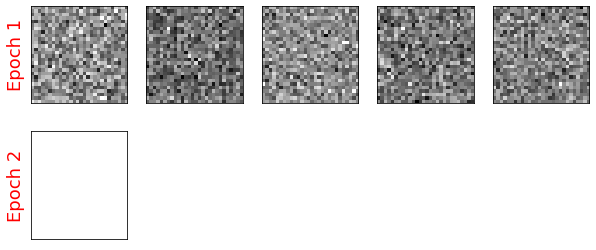

In [35]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6, 5, i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(
          -0.06, 0.5, 'Epoch {}'.format(e),
          rotation=90, size=18, color='red',
          horizontalalignment='right',
          verticalalignment='center',
          transform=ax.transAxes)
    image = epoch_samples[e-1][j]
    ax.imshow(image, cmap='gray_r')
plt.show()
